In [1]:
import time
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Dataset & DataLoader

In [3]:
transform = transforms.Compose([transforms.Resize([256,480]),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                                
])

In [ ]:
train = datasets.CIFAR10('~/data/', train=True, transform=transform,download=True)
test = datasets.CIFAR10('~/data/', train=False, transform=transform,download=True)

In [14]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=1)
dataloaders = {
    "train" : train_loader,
    "test" : test_loader
    
}

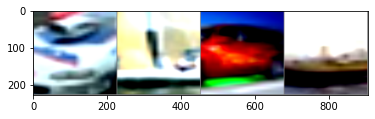

[tensor(1)] [tensor(8)] [tensor(1)] [tensor(8)]


In [19]:
#이미지 확인하기 
def imshow(img):
  img = img / 2 + 0.5 
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show() 

# 학습용 이미지 뽑기
dataiter = iter(train_loader)
images, labels = next(dataiter) 

# 이미지 보여주기 
imshow(torchvision.utils.make_grid(images[:4])) 
torchvision.utils.make_grid(images).shape

# 이미지별 라벨 (클래스) 보여주기 
print(' '.join('%5s' % [labels[j]] for j in range(4)))

### Model

In [25]:
# resnet 18, 34에서는 BasicBlock 사용
class BasicBlock(nn.Module):
  # expansion은 후에 모델의 깊이에 따라 다른 구조를 생성할 때 사용
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # residual function
        self.residual_function = nn.Sequential(
            # stride로 너비와 높이 조정
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # padding = 1, stride = 1로 너비와 높이 유지
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1,padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        # shortcut
        self.shortcut = nn.Sequential()

        # 만약 채널 사이즈가 맞지 않는다면, 1x1 conv로 차원 맞춰주기
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
    
    # F(x) + x
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))  

In [26]:
# resnet 50 이상부터는 BottleNeck구조 사용
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


In [27]:
class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    # 다양한 구조 생성을 위한 _make_layer 생성
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

In [28]:
def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])


In [29]:
def weight_init(model):
  if isinstance(model, nn.Linear):
    torch.nn.init.kaiming_uniform_(model.weight)
    model.bias.data.fill_(0.01)

In [30]:
model = resnet34()
model.apply(weight_init)
model.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [31]:
learning_rate = 0.1
num_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = learning_rate , momentum=0.9,weight_decay=0.0001)

In [32]:
def train_model(model, dataloaders,criterion,optimizer,num_epochs):
    start_time = time.time()
    max_accuracy = 0
    min_loss = int(1e9)
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {"train_loss":[],"train_acc":[],"test_loss":[],"test_acc":[]}
    
    
    for epoch in range(num_epochs):
        f1_list = []
        for phase in ['train', 'test']:
                if phase == 'train':
                    model.train() 
                else:
                    model.eval()   

                running_loss = 0.0
                running_acc = 0.0
                
                for step, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    running_loss += loss.item() * inputs.size(0)
                    running_acc += torch.sum(preds == labels.data)
                    

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_acc / len(dataloaders[phase].dataset)
                
                print(f"[Epoch : %d] [Phase : %s] epoch_loss : %.5f epoch_acc: %.2f" % 
                      (epoch+1, phase, epoch_loss, epoch_acc))
                
                if phase == "train":
                    history["train_loss"].append(epoch_loss)
                    history["train_acc"].append(epoch_acc)
                else:
                    history["test_loss"].append(epoch_loss)
                    history["test_acc"].append(epoch_acc)
                            
                if phase == "test" and max_accuracy < epoch_acc:
                    max_accuracy = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_point = 0
                    
                if phase == "test":
                  if min_loss < epoch_loss:
                    count += 1
                    if count > 10:
                      for g in optimizer.param_groups:
                        g['lr']/=10
                  else:
                    count = 0
                    
          
    print(time.time()-start_time)
    model.load_state_dict(best_model_wts)
    print("Done")
    return model,history

In [33]:
model_fit, history = train_model(model, dataloaders, criterion, optimizer, num_epochs)

  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 1] [Phase : train] epoch_loss : 2.47263 epoch_acc: 0.21


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 1] [Phase : test] epoch_loss : 2.01319 epoch_acc: 0.25


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 2] [Phase : train] epoch_loss : 1.82832 epoch_acc: 0.33


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 2] [Phase : test] epoch_loss : 1.71755 epoch_acc: 0.38


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 3] [Phase : train] epoch_loss : 1.66123 epoch_acc: 0.39


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 3] [Phase : test] epoch_loss : 1.57394 epoch_acc: 0.42


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 4] [Phase : train] epoch_loss : 1.51895 epoch_acc: 0.45


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 4] [Phase : test] epoch_loss : 1.44583 epoch_acc: 0.47


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 5] [Phase : train] epoch_loss : 1.40639 epoch_acc: 0.49


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 5] [Phase : test] epoch_loss : 1.43188 epoch_acc: 0.49


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 6] [Phase : train] epoch_loss : 1.27678 epoch_acc: 0.54


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 6] [Phase : test] epoch_loss : 1.22501 epoch_acc: 0.56


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 7] [Phase : train] epoch_loss : 1.16267 epoch_acc: 0.58


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 7] [Phase : test] epoch_loss : 1.16852 epoch_acc: 0.59


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 8] [Phase : train] epoch_loss : 1.06491 epoch_acc: 0.62


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 8] [Phase : test] epoch_loss : 1.11374 epoch_acc: 0.61


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 9] [Phase : train] epoch_loss : 0.98446 epoch_acc: 0.65


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 9] [Phase : test] epoch_loss : 1.05114 epoch_acc: 0.62


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 10] [Phase : train] epoch_loss : 0.92881 epoch_acc: 0.67


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 10] [Phase : test] epoch_loss : 1.01918 epoch_acc: 0.65


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 11] [Phase : train] epoch_loss : 0.87519 epoch_acc: 0.69


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 11] [Phase : test] epoch_loss : 0.94455 epoch_acc: 0.67


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 12] [Phase : train] epoch_loss : 0.83058 epoch_acc: 0.71


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 12] [Phase : test] epoch_loss : 0.88072 epoch_acc: 0.69


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 13] [Phase : train] epoch_loss : 0.79715 epoch_acc: 0.72


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 13] [Phase : test] epoch_loss : 0.90753 epoch_acc: 0.68


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 14] [Phase : train] epoch_loss : 0.75071 epoch_acc: 0.74


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 14] [Phase : test] epoch_loss : 0.88297 epoch_acc: 0.70


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 15] [Phase : train] epoch_loss : 0.71380 epoch_acc: 0.75


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 15] [Phase : test] epoch_loss : 0.82572 epoch_acc: 0.72


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 16] [Phase : train] epoch_loss : 0.67859 epoch_acc: 0.76


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 16] [Phase : test] epoch_loss : 0.81729 epoch_acc: 0.72


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 17] [Phase : train] epoch_loss : 0.64690 epoch_acc: 0.77


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 17] [Phase : test] epoch_loss : 0.77664 epoch_acc: 0.73


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 18] [Phase : train] epoch_loss : 0.61965 epoch_acc: 0.78


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 18] [Phase : test] epoch_loss : 0.77154 epoch_acc: 0.74


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 19] [Phase : train] epoch_loss : 0.58553 epoch_acc: 0.80


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 19] [Phase : test] epoch_loss : 0.68139 epoch_acc: 0.77


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 20] [Phase : train] epoch_loss : 0.55511 epoch_acc: 0.81


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 20] [Phase : test] epoch_loss : 0.73516 epoch_acc: 0.75


  0%|          | 0/196 [00:00<?, ?it/s]

[Epoch : 21] [Phase : train] epoch_loss : 0.53451 epoch_acc: 0.81


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 21] [Phase : test] epoch_loss : 0.67584 epoch_acc: 0.77


  0%|          | 0/196 [00:00<?, ?it/s]

KeyboardInterrupt: ignored